# 붓꽃 판별

## 패키지 로딩

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix, classification_report, roc_auc_score

## 데이터 로드 및 확인

In [2]:
iris = load_iris()
x = iris.data
y = iris.target
print(x.shape)

(150, 4)


## 학습 데이터/평가 데이터 분석

In [3]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8,random_state=10, stratify=y)

In [4]:
print('y의 클래스별 데이터:', np.bincount(y))  # bincount = value.count와 비슷, 데이터별 빈도 수 체크
print('y_train의 클래스별 데이터:', np.bincount(y_train))
print('y_test의 클래스별 데이터:', np.bincount(y_test))

y의 클래스별 데이터: [50 50 50]
y_train의 클래스별 데이터: [40 40 40]
y_test의 클래스별 데이터: [10 10 10]


## 모델 생성
- multi-class: 다중분류 문제를 처리하기 위한 방식 지정
>- solver가 liblinear로 지정된 경우에는 one-versus-rest(ovr) 방식으로 제한된다.

In [5]:
model = LogisticRegression(solver='liblinear', multi_class='ovr', max_iter=2000)   # max_iter = 결과 출력 위한 반복 횟수
model.fit(x_train, y_train)

LogisticRegression(max_iter=2000, multi_class='ovr', solver='liblinear')

## 모델 예측

In [6]:
print(iris.target_names)

['setosa' 'versicolor' 'virginica']


In [7]:
y_hat = model.predict(x_test)
print(y_hat[:5])

[1 0 2 2 1]


In [9]:
# 예측 확률 값 찍기
prob = model.predict_proba(x_test)
print(np.round(prob[:5],3))

[[0.015 0.548 0.437]
 [0.902 0.097 0.   ]
 [0.014 0.348 0.638]
 [0.005 0.395 0.601]
 [0.129 0.723 0.149]]


In [10]:
# 확률의 모든 합 = 1
print(np.sum(prob[:5], axis=1))

[1. 1. 1. 1. 1.]


## 모델 평가
- 다중 클래스의 분류의 경우, average 속성에 집계 방식(macro, micro, weight) 지정해야 함

In [11]:
# 다른 것들은 괜찮지만 다지분류의 roc는 유의해야 함

print(f'정확도:{accuracy_score(y_test, y_hat):.3f}')
print(f'정밀도:{precision_score(y_test, y_hat, average="macro"):.3f}')
print(f'F1-Score:{f1_score(y_test, y_hat, average="micro"):.3f}')

정확도:0.967
정밀도:0.970
F1-Score:0.967


- 다중 클래스 분류의 ROC
>- ROC 곡선은 일반적으로 TPR과 FPR을 명확하게 정의할 수 있는 이진 분류에 사용된다.
>- 다중 클래스 분류의 경우 출력을 이진화한 후에만 TPR과 FPR의 값을 얻을 수 있다.
>- 따라서 이 작업은 One-vs-Rest 또는 One-vs-One 두 가지 방법으로 수행할 수 있다.

In [12]:
auc = roc_auc_score(y_test, model.predict_proba(x_test), multi_class='ovr')  # 전체 예측 확률값 넣어 줌
print(f'AUC:{auc:.3f}')

AUC:0.988


In [31]:
report = classification_report(y_test, y_hat)
print(report)    # support = 샘플 개수

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.90      0.95        10
           2       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



## 다중 클래스 혼동행렬 시각화

In [35]:
!pip install seaborn --upgrade

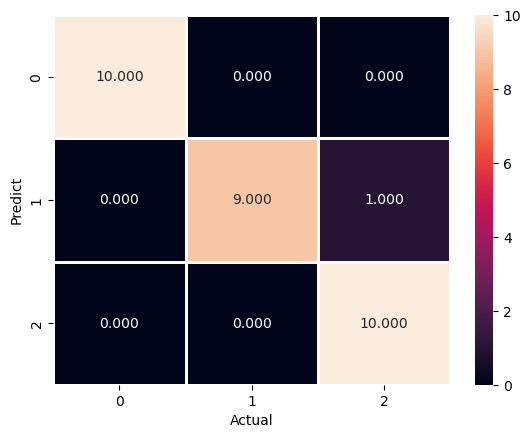

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(confusion_matrix(y_test, y_hat), annot=True, fmt='.3f', linewidths=1)
plt.xlabel('Actual')
plt.ylabel('Predict')
plt.show()

## 하이퍼 파라메터 튜닝

In [18]:
from sklearn.model_selection import GridSearchCV

model = LogisticRegression()
params = {
    'C':[0.01, 0.1, 1, 3, 5, 10],
    'solver':['newton-cg','lbfgs','sag','saga','liblinear'],
    'multi_class':['ovr','multinomial']
}
# n_jobs - 코어 사용 개수 지정. (default= 1)  -1 = 모두 사용
gs = GridSearchCV(model, params, cv=5, scoring='accuracy', n_jobs=-1)  # cv = 교차 검증 폴딩 수
gs.fit(x,y)   # 교차 검증 (전체 데이터)
print('최적 파라메터:', gs.best_params_)
print('최적 정확도:', gs.best_score_)

최적 파라메터: {'C': 1, 'multi_class': 'multinomial', 'solver': 'sag'}
최적 정확도: 0.9800000000000001


C:\Users\user\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
30 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1207, in fit
    multi_class = _check_multi_class(self.multi_class, solver, len(self.classes_))
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\user\anaconda3\Lib\site-

## 최적 파라메터를 이용한 모델 평가

In [22]:
y_hat = gs.best_estimator_.predict(x_test)
print(f'정확도:{accuracy_score(y_test, y_hat):.3f}')
auc = roc_auc_score(y_test, gs.best_estimator_.predict_proba(x_test), multi_class='ovr')
print('AUC', auc)

정확도:1.000
AUC 1.0
